# DFT Exchange

In [3]:
library(boot)
library(data.table)

#### READ DATAS

In [4]:
# Desired columns out of data frame
col <- c("dimer", "complex", "int_bm", "int_DFT", "int_DFT_X", "int_DFT_C", "int_HF_X", "int_DFT_D3")

In [5]:
data1.dt <- read.csv("s66_pbe_vtz.csv", header=TRUE, sep=",")
data1.df <- data.frame(data1.dt[col])
data1.df["diff_HFX_DFTX"] <- data1.df$int_HF_X - data1.df$int_DFT_X

#### FUNCTIONS

In [6]:
# Round all values in data frame
round.fn <- function(dt, n) {
    is.num <- sapply(dt, is.numeric)
    dt[is.num] <- lapply(dt[is.num], round, n)
    return(dt)
}

In [7]:
# !!! Add MAE, RMS, RMSD, RMSE
mae <- function(x) {
    mean(abs(x), na.rm = TRUE)
}

rmsd <- function(x) {
    sqrt(mean(x^2, na.rm = TRUE))
}

classic.stats.fn <- function(x) {
    a = c(
        # Average value
        mean(x, na.rm = TRUE),
        # Median absolute deviation
        mad(x, na.rm = TRUE),
        # Mean absolute error 
        mae(x),
        # Root mean squared deviation
        rmsd(x),
        # Standard deviation
        sd(x, na.rm = TRUE),
        # Minimum value
        min(x, na.rm = TRUE),
        # Maximum value
        max(x, na.rm = TRUE)
        )
    return(a)
}

In [8]:
# BOOTSTRAPPING METHOD
# boot_comp := stats.vec

ci.out.fn <- function(dt, boot_comp, stat.fn) {
    bootstr.out <- boot(data = dt, R = 10000, statistic = stat.fn, 
                        parallel = "multicore", ncpus = 6)
    
    n_stats = length(boot_comp)
    
    boot.stat.dt <- data.table(component = character(), stat = double(), lower = double(), upper = double())
    
    for (i in 1:n_stats) {
        ci.out <- boot.ci(bootstr.out, index = as.integer(i), type = "basic", conf = 0.95) 
        my_list <- list(boot_comp[i], ci.out$t0, ci.out$basic[4], ci.out$basic[5])
        boot.stat.dt = rbind(boot.stat.dt, my_list)
    }
    
    return(boot.stat.dt)
}

In [33]:
whichfitmodel <- 4.1

In [34]:
# FITTING-MODELS

fitmod <- whichfitmodel

if (fitmod == 1) {
    
    fitmodel.fn <- function(dt, x, y){
        x = c("int_DFT_X", "int_HF_X", "0")
        y = "int_bm - int_DFT"
        indep = paste(x, collapse = " + ")
        my.formula = paste(y, " ~ ", indep, sep = "")           
        fit_data <- lm(formula = my.formula, data = dt)  
        return(fit_data)
    }
    
    get.out.fitmodel.fn <- function(dt, indices, x, y){
        x = c("int_DFT_X", "int_HF_X", "0")
        y = "int_bm - int_DFT"
        indep = paste(x, collapse = " + ")
        my.formula = paste(y, " ~ ", indep, sep = "")
        d = dt[indices,]                                  # allows boot to select sample
        fit_data <- lm(formula = my.formula, data = d)  
        sumfit <- summary(fit_data)
        fit.out.dt <- c(coef(sumfit), sumfit$r.squared, classic.stats.fn(resid(sumfit)))
        return(fit.out.dt)
    }
    
    sm.get.out.fitmodel.fn <- function(dt, indices, x, y){
        x = c("int_DFT_X", "int_HF_X", "0")
        y = "int_bm - int_DFT"
        indep = paste(x, collapse = " + ")
        my.formula = paste(y, " ~ ", indep, sep = "")
        d = dt[indices,]                                  # allows boot to select sample
        fit_data <- lm(formula = my.formula, data = d)  
        sumfit <- summary(fit_data)
        fit.out.dt <- c(coef(sumfit)[1:4], sumfit$r.squared, classic.stats.fn(resid(sumfit)))
        return(fit.out.dt)
    }
    
    stats.vec <- c("DFTX.coef", "HFX.coeff", 
                 "DFTX.stderr", "HFX.stderr", 
                 "DFTX.tval", "HFX.tval", 
                 "DFTX.pval", "HFX.pval", 
                 "R.squ", "MEAN", "MAD", "MAE", "RMSD", "SD", "Min", "Max")
    
    stats.vec.sm <- c("DFTX.coef", "HFX.coeff", "DFTX.stderr", "HFX.stderr", 
                    "R.squ", "MEAN", "MAD", "MAE", "RMSD", "SD", "Min", "Max")
}

if (fitmod == 1.1) {
    
    fitmodel.fn <- function(dt, x, y){
        x = c("int_DFT_X", "int_HF_X", "0")
        y = "int_bm - int_DFT + int_DFT_X + int_DFT_C"
        indep = paste(x, collapse = " + ")
        my.formula = paste(y, " ~ ", indep, sep = "")           
        fit_data <- lm(formula = my.formula, data = dt)  
        return(fit_data)
    }
    
    get.out.fitmodel.fn <- function(dt, indices, x, y){
        x = c("int_DFT_X", "int_HF_X", "0")
        y = "int_bm - int_DFT + int_DFT_X + int_DFT_C"
        indep = paste(x, collapse = " + ")
        my.formula = paste(y, " ~ ", indep, sep = "")
        d = dt[indices,]                                  # allows boot to select sample
        fit_data <- lm(formula = my.formula, data = d)  
        sumfit <- summary(fit_data)
        fit.out.dt <- c(coef(sumfit), sumfit$r.squared, classic.stats.fn(resid(sumfit)))
        return(fit.out.dt)
    }
    
    sm.get.out.fitmodel.fn <- function(dt, indices, x, y){
        x = c("int_DFT_X", "int_HF_X", "0")
        y = "int_bm - int_DFT + int_DFT_X + int_DFT_C"
        indep = paste(x, collapse = " + ")
        my.formula = paste(y, " ~ ", indep, sep = "")
        d = dt[indices,]                                  # allows boot to select sample
        fit_data <- lm(formula = my.formula, data = d)  
        sumfit <- summary(fit_data)
        fit.out.dt <- c(coef(sumfit)[1:4], sumfit$r.squared, classic.stats.fn(resid(sumfit)))
        return(fit.out.dt)
    }
    
    stats.vec <- c("DFTX.coef", "HFX.coeff", 
                 "DFTX.stderr", "HFX.stderr", 
                 "DFTX.tval", "HFX.tval", 
                 "DFTX.pval", "HFX.pval", 
                 "R.squ", "MEAN", "MAD", "MAE", "RMSD", "SD", "Min", "Max")
    
    stats.vec.sm <- c("DFTX.coef", "HFX.coeff", "DFTX.stderr", "HFX.stderr", 
                    "R.squ", "MEAN", "MAD", "MAE", "RMSD", "SD", "Min", "Max")
}

if (fitmod == 2) {
    
    fitmodel.fn <- function(dt, x, y) {
        x = c("int_DFT_X", "int_HF_X", "int_DFT_C", "0")
        y = "int_bm - int_DFT"
        indep = paste(x, collapse = " + ")
        my.formula = paste(y, "~", indep, sep = "")
        fit_data <- lm(formula = my.formula, data = dt)
        return(fit_data)
    }
    
    get.out.fitmodel.fn <- function(dt, indices, x, y){
        x = c("int_DFT_X", "int_HF_X", "int_DFT_C", "0")
        y = "int_bm - int_DFT"
        indep = paste(x, collapse = " + ")
        my.formula = paste(y, " ~ ", indep, sep = "")
        d = dt[indices,]                                       # allows boot to select sample
        fit_data <- lm(formula = my.formula, data = d)  
        sumfit <- summary(fit_data)
        fit.out.dt <- c(coef(sumfit), sumfit$r.squared, classic.stats.fn(resid(sumfit)))
        return(fit.out.dt)
    }
    
    sm.get.out.fitmodel.fn <- function(dt, indices, x, y){
        x = c("int_DFT_X", "int_HF_X", "int_DFT_C", "0")
        y = "int_bm - int_DFT"
        indep = paste(x, collapse = " + ")
        my.formula = paste(y, " ~ ", indep, sep = "")
        d = dt[indices,]                                       # allows boot to select sample
        fit_data <- lm(formula = my.formula, data = d)  
        sumfit <- summary(fit_data)
        fit.out.dt <- c(coef(sumfit)[1:4], sumfit$r.squared, classic.stats.fn(resid(sumfit)))
        return(fit.out.dt)
    }
    
    stats.vec <- c("DFTX.coef", "HFX.coeff", "DFTC.coef", 
                 "DFTX.stderr", "HFX.stderr", "DFTC.stderr", 
                 "DFTX.tval", "HFX.tval", "DFTC.tval", 
                 "DFTX.pval", "HFX.pval", "DFTC.pval",
                 "R.squ", "MEAN", "MAD", "MAE", "RMSD", "SD", "Min", "Max")
    
    stats.vec.sm <- c("DFTX.coef", "HFX.coeff", "DFTC.coef", 
                 "DFTX.stderr", "HFX.stderr", "DFTC.stderr", 
                 "R.squ", "MEAN", "MAD", "MAE", "RMSD", "SD", "Min", "Max")
    
}

if (fitmod == 2.1) {
    
    fitmodel.fn <- function(dt, x, y) {
        x = c("int_DFT_X", "int_HF_X", "int_DFT_C", "0")
        y = "int_bm - int_DFT + int_DFT_X + int_DFT_C"
        indep = paste(x, collapse = " + ")
        my.formula = paste(y, "~", indep, sep = "")
        fit_data <- lm(formula = my.formula, data = dt)
        return(fit_data)
    }
    
    get.out.fitmodel.fn <- function(dt, indices, x, y){
        x = c("int_DFT_X", "int_HF_X", "int_DFT_C", "0")
        y = "int_bm - int_DFT + int_DFT_X + int_DFT_C"
        indep = paste(x, collapse = " + ")
        my.formula = paste(y, " ~ ", indep, sep = "")
        d = dt[indices,]                                       # allows boot to select sample
        fit_data <- lm(formula = my.formula, data = d)  
        sumfit <- summary(fit_data)
        fit.out.dt <- c(coef(sumfit), sumfit$r.squared, classic.stats.fn(resid(sumfit)))
        return(fit.out.dt)
    }
    
    sm.get.out.fitmodel.fn <- function(dt, indices, x, y){
        x = c("int_DFT_X", "int_HF_X", "int_DFT_C", "0")
        y = "int_bm - int_DFT + int_DFT_X + int_DFT_C"
        indep = paste(x, collapse = " + ")
        my.formula = paste(y, " ~ ", indep, sep = "")
        d = dt[indices,]                                       # allows boot to select sample
        fit_data <- lm(formula = my.formula, data = d)  
        sumfit <- summary(fit_data)
        fit.out.dt <- c(coef(sumfit)[1:4], sumfit$r.squared, classic.stats.fn(resid(sumfit)))
        return(fit.out.dt)
    }
    
    stats.vec <- c("DFTX.coef", "HFX.coeff", "DFTC.coef", 
                 "DFTX.stderr", "HFX.stderr", "DFTC.stderr", 
                 "DFTX.tval", "HFX.tval", "DFTC.tval", 
                 "DFTX.pval", "HFX.pval", "DFTC.pval",
                 "R.squ", "MEAN", "MAD", "MAE", "RMSD", "SD", "Min", "Max")
    
    stats.vec.sm <- c("DFTX.coef", "HFX.coeff", "DFTC.coef", 
                 "DFTX.stderr", "HFX.stderr", "DFTC.stderr", 
                 "R.squ", "MEAN", "MAD", "MAE", "RMSD", "SD", "Min", "Max")
    
}

if (fitmod == 2.2) {
    
    fitmodel.fn <- function(dt, x, y) {
        x = c("int_DFT_X", "int_HF_X", "int_DFT_C", "0")
        y = "int_bm - int_DFT + int_DFT_C"
        indep = paste(x, collapse = " + ")
        my.formula = paste(y, "~", indep, sep = "")
        fit_data <- lm(formula = my.formula, data = dt)
        return(fit_data)
    }
    
    get.out.fitmodel.fn <- function(dt, indices, x, y){
        x = c("int_DFT_X", "int_HF_X", "int_DFT_C", "0")
        y = "int_bm - int_DFT + int_DFT_C"
        indep = paste(x, collapse = " + ")
        my.formula = paste(y, " ~ ", indep, sep = "")
        d = dt[indices,]                                       # allows boot to select sample
        fit_data <- lm(formula = my.formula, data = d)  
        sumfit <- summary(fit_data)
        fit.out.dt <- c(coef(sumfit), sumfit$r.squared, classic.stats.fn(resid(sumfit)))
        return(fit.out.dt)
    }
    
    sm.get.out.fitmodel.fn <- function(dt, indices, x, y){
        x = c("int_DFT_X", "int_HF_X", "int_DFT_C", "0")
        y = "int_bm - int_DFT + int_DFT_C"
        indep = paste(x, collapse = " + ")
        my.formula = paste(y, " ~ ", indep, sep = "")
        d = dt[indices,]                                       # allows boot to select sample
        fit_data <- lm(formula = my.formula, data = d)  
        sumfit <- summary(fit_data)
        fit.out.dt <- c(coef(sumfit)[1:4], sumfit$r.squared, classic.stats.fn(resid(sumfit)))
        return(fit.out.dt)
    }
    
    stats.vec <- c("DFTX.coef", "HFX.coeff", "DFTC.coef", 
                 "DFTX.stderr", "HFX.stderr", "DFTC.stderr", 
                 "DFTX.tval", "HFX.tval", "DFTC.tval", 
                 "DFTX.pval", "HFX.pval", "DFTC.pval",
                 "R.squ", "MEAN", "MAD", "MAE", "RMSD", "SD", "Min", "Max")
    
    stats.vec.sm <- c("DFTX.coef", "HFX.coeff", "DFTC.coef", 
                 "DFTX.stderr", "HFX.stderr", "DFTC.stderr", 
                 "R.squ", "MEAN", "MAD", "MAE", "RMSD", "SD", "Min", "Max")
    
}

if (fitmod == 3) {
    
    fitmodel.fn <- function(dt, x, y) {
        x = c("int_HF_X", "0")
        y = "int_bm - int_DFT + int_DFT_X"
        indep = paste(x, collapse = " + ")
        my.formula = paste(y, "~", indep, sep = "")
        fit_data <- lm(formula = my.formula, data = dt)
        return(fit_data)
    }
    
    get.out.fitmodel.fn <- function(dt, indices, x, y){
        x = c("int_HF_X", "0")
        y = "int_bm - int_DFT + int_DFT_X"
        indep = paste(x, collapse = " + ")
        my.formula = paste(y, " ~ ", indep, sep = "")
        d = dt[indices,]                                       # allows boot to select sample
        fit_data <- lm(formula = my.formula, data = d)  
        sumfit <- summary(fit_data)
        fit.out.dt <- c(coef(sumfit), sumfit$r.squared, classic.stats.fn(resid(sumfit)))
        return(fit.out.dt)
    }
    
    sm.get.out.fitmodel.fn <- function(dt, indices, x, y){
        x = c("int_HF_X", "0")
        y = "int_bm - int_DFT + int_DFT_X"
        indep = paste(x, collapse = " + ")
        my.formula = paste(y, " ~ ", indep, sep = "")
        d = dt[indices,]                                       # allows boot to select sample
        fit_data <- lm(formula = my.formula, data = d)  
        sumfit <- summary(fit_data)
        fit.out.dt <- c(coef(sumfit)[1:4], sumfit$r.squared, classic.stats.fn(resid(sumfit)))
        return(fit.out.dt)
    }
    
    stats.vec <- c("HFX.coeff", "HFX.stderr", "HFX.tval", "HFX.pval",
                 "R.squ", "MEAN", "MAD", "MAE", "RMSD", "SD", "Min", "Max")
    
    stats.vec.sm <- c("HFX.coeff", "HFX.stderr",
                 "R.squ", "MEAN", "MAD", "MAE", "RMSD", "SD", "Min", "Max")
    
}

if (fitmod == 4) {
    
    fitmodel.fn <- function(dt, x, y) {
        x = c("int_HF_X", "int_DFT_C", "0")
        y = "int_bm - int_DFT + int_DFT_X"
        indep = paste(x, collapse = " + ")
        my.formula = paste(y, "~", indep, sep = "")
        fit_data <- lm(formula = my.formula, data = dt)
        return(fit_data)
    }
    
    get.out.fitmodel.fn <- function(dt, indices, x, y){
        x = c("int_HF_X", "int_DFT_C", "0")
        y = "int_bm - int_DFT + int_DFT_X"
        indep = paste(x, collapse = " + ")
        my.formula = paste(y, " ~ ", indep, sep = "")
        d = dt[indices,]                                       # allows boot to select sample
        fit_data <- lm(formula = my.formula, data = d)  
        sumfit <- summary(fit_data)
        fit.out.dt <- c(coef(sumfit), sumfit$r.squared, classic.stats.fn(resid(sumfit)))
        return(fit.out.dt)
    }
    
    sm.get.out.fitmodel.fn <- function(dt, indices, x, y){
        x = c("int_HF_X", "int_DFT_C", "0")
        y = "int_bm - int_DFT + int_DFT_X"
        indep = paste(x, collapse = " + ")
        my.formula = paste(y, " ~ ", indep, sep = "")
        d = dt[indices,]                                       # allows boot to select sample
        fit_data <- lm(formula = my.formula, data = d)  
        sumfit <- summary(fit_data)
        fit.out.dt <- c(coef(sumfit)[1:4], sumfit$r.squared, classic.stats.fn(resid(sumfit)))
        return(fit.out.dt)
    }
    
    stats.vec <- c("HFX.coef", "DFTC.coeff", 
                 "HFX.stderr", "DFTC.stderr", 
                 "HFX.tval", "DFTC.tval", 
                 "HFX.pval", "DFTC.pval", 
                 "R.squ", "MEAN", "MAD", "MAE", "RMSD", "SD", "Min", "Max")
    
    stats.vec.sm <- c("HFX.coef", "DFTC.coeff", 
                 "HFX.stderr", "DFTC.stderr",  
                 "R.squ", "MEAN", "MAD", "MAE", "RMSD", "SD", "Min", "Max")
    
}

if (fitmod == 4.1) {
    
    fitmodel.fn <- function(dt, x, y) {
        x = c("int_HF_X", "int_DFT_C", "0")
        y = "int_bm - int_DFT + int_DFT_X + int_DFT_C"
        indep = paste(x, collapse = " + ")
        my.formula = paste(y, "~", indep, sep = "")
        fit_data <- lm(formula = my.formula, data = dt)
        return(fit_data)
    }
    
    get.out.fitmodel.fn <- function(dt, indices, x, y){
        x = c("int_HF_X", "int_DFT_C", "0")
        y = "int_bm - int_DFT + int_DFT_X + int_DFT_C"
        indep = paste(x, collapse = " + ")
        my.formula = paste(y, " ~ ", indep, sep = "")
        d = dt[indices,]                                       # allows boot to select sample
        fit_data <- lm(formula = my.formula, data = d)  
        sumfit <- summary(fit_data)
        fit.out.dt <- c(coef(sumfit), sumfit$r.squared, classic.stats.fn(resid(sumfit)))
        return(fit.out.dt)
    }
    
    sm.get.out.fitmodel.fn <- function(dt, indices, x, y){
        x = c("int_HF_X", "int_DFT_C", "0")
        y = "int_bm - int_DFT + int_DFT_X + int_DFT_C"
        indep = paste(x, collapse = " + ")
        my.formula = paste(y, " ~ ", indep, sep = "")
        d = dt[indices,]                                       # allows boot to select sample
        fit_data <- lm(formula = my.formula, data = d)  
        sumfit <- summary(fit_data)
        fit.out.dt <- c(coef(sumfit)[1:4], sumfit$r.squared, classic.stats.fn(resid(sumfit)))
        return(fit.out.dt)
    }
    
    stats.vec <- c("HFX.coef", "DFTC.coeff", 
                 "HFX.stderr", "DFTC.stderr", 
                 "HFX.tval", "DFTC.tval", 
                 "HFX.pval", "DFTC.pval", 
                 "R.squ", "MEAN", "MAD", "MAE", "RMSD", "SD", "Min", "Max")
    
    stats.vec.sm <- c("HFX.coef", "DFTC.coeff", 
                 "HFX.stderr", "DFTC.stderr",  
                 "R.squ", "MEAN", "MAD", "MAE", "RMSD", "SD", "Min", "Max")
    
}

if (fitmod == 5) {
    
    fitmodel.fn <- function(dt, x, y) {
        x = c("int_HF_X", "0")
        y = "int_bm - int_DFT + int_DFT_X - int_DFT_C"
        indep = paste(x, collapse = " + ")
        my.formula = paste(y, "~", indep, sep = "")
        fit_data <- lm(formula = my.formula, data = dt)
        return(fit_data)
    }
    
    get.out.fitmodel.fn <- function(dt, indices, x, y){
        x = c("int_HF_X", "0")
        y = "int_bm - int_DFT + int_DFT_X - int_DFT_C"
        indep = paste(x, collapse = " + ")
        my.formula = paste(y, " ~ ", indep, sep = "")
        d = dt[indices,]                                       # allows boot to select sample
        fit_data <- lm(formula = my.formula, data = d)  
        sumfit <- summary(fit_data)
        fit.out.dt <- c(coef(sumfit), sumfit$r.squared, classic.stats.fn(resid(sumfit)))
        return(fit.out.dt)
    }
    
    sm.get.out.fitmodel.fn <- function(dt, indices, x, y){
        x = c("int_HF_X", "0")
        y = "int_bm - int_DFT + int_DFT_X - int_DFT_C"
        indep = paste(x, collapse = " + ")
        my.formula = paste(y, " ~ ", indep, sep = "")
        d = dt[indices,]                                       # allows boot to select sample
        fit_data <- lm(formula = my.formula, data = d)  
        sumfit <- summary(fit_data)
        fit.out.dt <- c(coef(sumfit)[1:4], sumfit$r.squared, classic.stats.fn(resid(sumfit)))
        return(fit.out.dt)
    }
    
    stats.vec <- c("HFX.coeff", "HFX.stderr", "HFX.tval", "HFX.pval",
                 "R.squ", "MEAN", "MAD", "MAE", "RMSD", "SD", "Min", "Max")
    
    stats.vec.sm <- c("HFX.coeff", "HFX.stderr",
                 "R.squ", "MEAN", "MAD", "MAE", "RMSD", "SD", "Min", "Max")
    
}

if (fitmod == 6) {
    
    fitmodel.fn <- function(dt, x, y) {
        x = c("diff_int_HFX_vs_DFTX", "int_DFT_C", "0")
        y = "int_bm - int_DFT"
        indep = paste(x, collapse = " + ")
        my.formula = paste(y, "~", indep, sep = "")
        fit_data <- lm(formula = my.formula, data = dt)
        return(fit_data)
    }
    
    get.out.fitmodel.fn <- function(dt, indices, x, y){
        x = c("diff_int_HFX_vs_DFTX", "int_DFT_C", "0")
        y = "int_bm - int_DFT"
        indep = paste(x, collapse = " + ")
        my.formula = paste(y, " ~ ", indep, sep = "")
        d = dt[indices,]                                       # allows boot to select sample
        fit_data <- lm(formula = my.formula, data = d)  
        sumfit <- summary(fit_data)
        fit.out.dt <- c(coef(sumfit), sumfit$r.squared, classic.stats.fn(resid(sumfit)))
        return(fit.out.dt)
    }
    
    sm.get.out.fitmodel.fn <- function(dt, indices, x, y){
        x = c("diff_int_HFX_vs_DFTX", "int_DFT_C", "0")
        y = "int_bm - int_DFT"
        indep = paste(x, collapse = " + ")
        my.formula = paste(y, " ~ ", indep, sep = "")
        d = dt[indices,]                                       # allows boot to select sample
        fit_data <- lm(formula = my.formula, data = d)  
        sumfit <- summary(fit_data)
        fit.out.dt <- c(coef(sumfit)[1:4], sumfit$r.squared, classic.stats.fn(resid(sumfit)))
        return(fit.out.dt)
    }
    
    stats.vec <- c("hybX.coef", "DFTC.coeff", 
                 "hybX.stderr", "DFTC.stderr", 
                 "hybX.tval", "DFTC.tval", 
                 "hybX.pval", "DFTC.pval", 
                 "R.squ", "MEAN", "MAD", "MAE", "RMSD", "SD", "Min", "Max")
    
    stats.vec.sm <- c("hybX.coef", "DFTC.coeff", 
                 "hybX.stderr", "DFTC.stderr", 
                 "R.squ", "MEAN", "MAD", "MAE", "RMSD", "SD", "Min", "Max")
    
}

if (fitmod == 7) {
    
    fitmodel.fn <- function(dt, x, y) {
        x = c("diff_int_HFX_vs_DFTX", "0")
        y = "int_bm - int_DFT - int_DFT_C"
        indep = paste(x, collapse = " + ")
        my.formula = paste(y, "~", indep, sep = "")
        fit_data <- lm(formula = my.formula, data = dt)
        return(fit_data)
    }
    
    get.out.fitmodel.fn <- function(dt, indices, x, y){
        x = c("diff_int_HFX_vs_DFTX", "0")
        y = "int_bm - int_DFT - int_DFT_C"
        indep = paste(x, collapse = " + ")
        my.formula = paste(y, " ~ ", indep, sep = "")
        d = dt[indices,]                                       # allows boot to select sample
        fit_data <- lm(formula = my.formula, data = d)  
        sumfit <- summary(fit_data)
        fit.out.dt <- c(coef(sumfit), sumfit$r.squared, classic.stats.fn(resid(sumfit)))
        return(fit.out.dt)
    }
    
    sm.get.out.fitmodel.fn <- function(dt, indices, x, y){
        x = c("diff_int_HFX_vs_DFTX", "0")
        y = "int_bm - int_DFT - int_DFT_C"
        indep = paste(x, collapse = " + ")
        my.formula = paste(y, " ~ ", indep, sep = "")
        d = dt[indices,]                                       # allows boot to select sample
        fit_data <- lm(formula = my.formula, data = d)  
        sumfit <- summary(fit_data)
        fit.out.dt <- c(coef(sumfit)[1:4], sumfit$r.squared, classic.stats.fn(resid(sumfit)))
        return(fit.out.dt)
    }
    
    stats.vec <- c("hybX.coeff", "hybX.stderr", "hybX.tval", "hybX.pval",
                 "R.squ", "MEAN", "MAD", "MAE", "RMSD", "SD", "Min", "Max")
    
    stats.vec.sm <- c("hybX.coeff", "hybX.stderr",
                 "R.squ", "MEAN", "MAD", "MAE", "RMSD", "SD", "Min", "Max")
    
}

if (fitmod == 8) {
    
    fitmodel.fn <- function(dt, x, y) {
        x = c("diff_HFX_DFTX", "0")
        y = "int_bm - int_DFT"
        indep = paste(x, collapse = " + ")
        my.formula = paste(y, "~", indep, sep = "")
        fit_data <- lm(formula = my.formula, data = dt)
        return(fit_data)
    }
    
    get.out.fitmodel.fn <- function(dt, indices, x, y){
        x = c("diff_HFX_DFTX", "0")
        y = "int_bm - int_DFT"
        indep = paste(x, collapse = " + ")
        my.formula = paste(y, " ~ ", indep, sep = "")
        d = dt[indices,]                                       # allows boot to select sample
        fit_data <- lm(formula = my.formula, data = d)  
        sumfit <- summary(fit_data)
        fit.out.dt <- c(coef(sumfit), sumfit$r.squared, classic.stats.fn(resid(sumfit)))
        return(fit.out.dt)
    }
    
    sm.get.out.fitmodel.fn <- function(dt, indices, x, y){
        x = c("diff_HFX_DFTX", "0")
        y = "int_bm - int_DFT"
        indep = paste(x, collapse = " + ")
        my.formula = paste(y, " ~ ", indep, sep = "")
        d = dt[indices,]                                       # allows boot to select sample
        fit_data <- lm(formula = my.formula, data = d)  
        sumfit <- summary(fit_data)
        fit.out.dt <- c(coef(sumfit)[1:4], sumfit$r.squared, classic.stats.fn(resid(sumfit)))
        return(fit.out.dt)
    }
    
    stats.vec <- c("hybX.coeff", "hybX.stderr", "hybX.tval", "hybX.pval",
                 "R.squ", "MEAN", "MAD", "MAE", "RMSD", "SD", "Min", "Max")
    
    stats.vec.sm <- c("hybX.coeff", "hybX.stderr",
                 "R.squ", "MEAN", "MAD", "MAE", "RMSD", "SD", "Min", "Max")
    
}



# DFT Exchange

## Statistics and Bootstrapping

In [13]:
round.fn(data.frame("component" = c("MEAN", "MAD", "MAE", "RMSD", "SD", "Min", "Max"), 
                    "stat" = classic.stats.fn(data1.df$int_DFT_D3 - data1.df$int_bm)), 
         n=3)

component,stat
MEAN,-0.333
MAD,1.334
MAE,1.170
RMSD,1.583
SD,1.559
Min,-5.600
Max,4.000


In [35]:
round.fn(dt = data.frame(ci.out.fn(dt = data1.df, boot_comp = stats.vec, stat.fn = get.out.fitmodel.fn)),
         n = 3)

component,stat,lower,upper
HFX.coef,0.694,0.661,0.736
DFTC.coeff,1.454,1.313,1.589
HFX.stderr,0.016,0.010,0.020
DFTC.stderr,0.058,0.045,0.071
HFX.tval,43.677,30.695,55.927
DFTC.tval,24.873,16.848,30.173
HFX.pval,0.000,0.000,0.000
DFTC.pval,0.000,0.000,0.000
R.squ,0.999,0.998,0.999
MEAN,0.238,0.072,0.438


In [11]:
# Using hybrid coefficient a = 0.25 from literature

data1.df["int_DFT_hyb"] <- data1.df$int_DFT + 0.25*(data1.df$int_HF_X - data1.df$int_DFT_X) 

round.fn(data.frame("component" = c("MEAN", "MAD", "MAE", "RMSD", "SD", "Min", "Max"), 
                    "stat" = classic.stats.fn(data1.df$int_DFT_hyb - data1.df$int_bm)), 
         n=3)

component,stat
MEAN,1.732
MAD,10.823
MAE,9.049
RMSD,10.855
SD,10.744
Min,-25.250
Max,30.125


### Systems with the absolute error > 4 kJ/mol

In [18]:
# Registering your data
gendata <- data2.df

# Fitting the data once again to get the summary, without bootstrapping!
fitmod.out <- fitmodel.fn(gendata)

# Calculating the relative errors
fitmod.df <- data.frame(gendata[col], 
                            "abserr_int_DFTX"=abs(resid(fitmod.out)), 
                            "abserr_int_DFT_D3"=abs(gendata$int_bm - gendata$int_DFT_D3),
                            "err_int_DFTX"=resid(fitmod.out),
                            "err_int_DFT_D3"=(gendata$int_DFT_D3 - gendata$int_bm),
                            "err_int_DFT"=(gendata$int_DFT - gendata$int_bm))
fitmod.df <- round.fn(dt = fitmod.df, n = 1)

# Both DFT-X and DFT-D3 gives absolute error > 4 kJ/mol
abserr_gt4_DFTX_and_DFTD3.dt <- fitmod.df[which(fitmod.df$abserr_int_DFTX >= 4 & fitmod.df$abserr_int_DFT_D3 >= 4), ]

# Only DFT-X gives absolute error > 4 kJ/mol, while DFT-D3 < 4 kJ/mol
abserr_gt4_DFTX.dt <- fitmod.df[which(fitmod.df$abserr_int_DFTX >= 4 & fitmod.df$abserr_int_DFT_D3 < 4), ]

# Only DFT-D3 gives absolute error > 4 kJ/mol, while DFT-X < 4 kJ/mol
abserr_gt4_DFTD3.dt <- fitmod.df[which(fitmod.df$abserr_int_DFTX < 4 & fitmod.df$abserr_int_DFT_D3 >= 4), ]

# Displaying datas
shcol <- c("dimer", "complex", "abserr_int_DFTX", "abserr_int_DFT_D3")
#abserr_gt4_DFTX_and_DFTD3.dt[shcol]
#abserr_gt4_DFTX.dt[shcol]
#abserr_gt4_DFTD3.dt[shcol]

In [21]:
fit_list = list()

for (x in names(ndata)) {
    # Registering your data
    gendata <- ndata[[x]]

    # Fitting the data once again to get the summary, without bootstrapping!
    fitmod.out <- fitmodel.fn(gendata)

    # Calculating the relative errors
    fitmod.df <- data.frame(gendata[col], 
                                "abserr_int_DFTX"=abs(resid(fitmod.out)), 
                                "abserr_int_DFT_D3"=abs(gendata$int_bm - gendata$int_DFT_D3),
                                "err_int_DFTX"=resid(fitmod.out),
                                "err_int_DFT_D3"=(gendata$int_DFT_D3 - gendata$int_bm),
                                "err_int_DFT"=(gendata$int_DFT - gendata$int_bm))
    fitmod.df <- round.fn(dt = fitmod.df, n = 1)
    name = paste("fit_", x, sep="")
    fit_list[[name]] <- fitmod.df
    
    shcol <- c("dimer", "complex", "abserr_int_DFTX", "abserr_int_DFT_D3")
    
    
    # Both DFT-X and DFT-D3 gives absolute error > 4 kJ/mol
    abserr_gt4_DFTX_and_DFTD3.dt <- fitmod.df[which(fitmod.df$abserr_int_DFTX >= 4 & fitmod.df$abserr_int_DFT_D3 >= 4), ]

    # Only DFT-X gives absolute error > 4 kJ/mol, while DFT-D3 < 4 kJ/mol
    abserr_gt4_DFTX.dt <- fitmod.df[which(fitmod.df$abserr_int_DFTX >= 4 & fitmod.df$abserr_int_DFT_D3 < 4), ]
    # Additional fitting for bad systems
    bstr_abserr_gt4_DFTX.df <- data.frame(ci.out.fn(dt = abserr_gt4_DFTX.dt, boot_comp = stats.vec.sm, stat.fn = sm.get.out.fitmodel.fn))
    data.frame(round.fn(dt = bstr_abserr_gt4_DFTX.df, n = 3))

    # Only DFT-D3 gives absolute error > 4 kJ/mol, while DFT-X < 4 kJ/mol
    abserr_gt4_DFTD3.dt <- fitmod.df[which(fitmod.df$abserr_int_DFTX < 4 & fitmod.df$abserr_int_DFT_D3 >= 4), ]

    # Displaying datas
    abserr_gt4_DFTX_and_DFTD3.dt[shcol]
    #abserr_gt4_DFTX.dt[shcol]
    #abserr_gt4_DFTD3.dt[shcol]
}

     component   stat   lower  upper
1    DFTX.coef -1.245  -1.686 -0.329
2    HFX.coeff  0.900   0.340  1.057
3  DFTX.stderr  0.273  -0.105  0.547
4   HFX.stderr  0.150   0.050  0.300
5        R.squ  0.951   0.903  0.966
6         MEAN -0.416  -0.887  0.030
7          MAD  1.099  -3.687  2.197
8           SD  3.645   2.372  7.289
9          Min -6.714 -13.428 -6.250
10         Max  2.645   0.362  5.291
     component   stat  lower  upper
1    DFTX.coef -0.879 -1.054 -0.722
2    HFX.coeff  0.768  0.674  0.869
3  DFTX.stderr  0.088  0.004  0.131
4   HFX.stderr  0.052  0.001  0.077
5        R.squ  1.000  0.999  1.000
6         MEAN  0.005 -0.040  0.047
7          MAD  1.122  0.873  2.162
8           SD  0.816  0.665  1.193
9          Min -1.355 -2.124 -1.033
10         Max  1.146  0.723  1.799
     component   stat  lower  upper
1    DFTX.coef -1.270 -1.404 -0.819
2    HFX.coeff  1.001  0.741  1.083
3  DFTX.stderr  0.085  0.041  0.118
4   HFX.stderr  0.050  0.026  0.069
5        R.squ  0

# PLOT

### S66

In [160]:
s66_fitmod.df <- fitmod.df
s66_elec.df <- s66_fitmod.df[1:23,]
s66_disp.df <- s66_fitmod.df[24:46,]
s66_mix.df <- s66_fitmod.df[47:66,]

ERROR: Error in eval(expr, envir, enclos): object 'fitmod.df' not found


In [16]:
int_type = c(rep("S66-electrostatics", 23), rep("S66-dispersion", 23), rep("S66-mixed", 20))
dft_func = rep(c("DFT", "DFT-D3", "DFTX"), each = 66)
err_DFT = c(rep(s66_elec.df$err_int_DFT), rep(s66_disp.df$err_int_DFT), rep(s66_mix.df$err_int_DFT))
err_DFT_D3 = c(rep(s66_elec.df$err_int_DFT_D3), rep(s66_disp.df$err_int_DFT_D3), rep(s66_mix.df$err_int_DFT_D3))
err_DFTX = c(rep(s66_elec.df$err_int_DFTX), rep(s66_disp.df$err_int_DFTX), rep(s66_mix.df$err_int_DFTX))
err_data = c(rep(err_DFT), rep(err_DFT_D3), rep(err_DFTX))
err_df <- data.frame(dft_func, int_type, err_data)
err_df$dft_func <- factor(err_df$dft_func, levels = c("DFT", "DFT-D3", "DFTX"))
err_df$int_type <- factor(err_df$int_type, levels = c("S66-electrostatics", "S66-dispersion", "S66-mixed"))
is.num <- sapply(err_df, is.numeric)
err_df[is.num] <- lapply(err_df[is.num], round, 1)

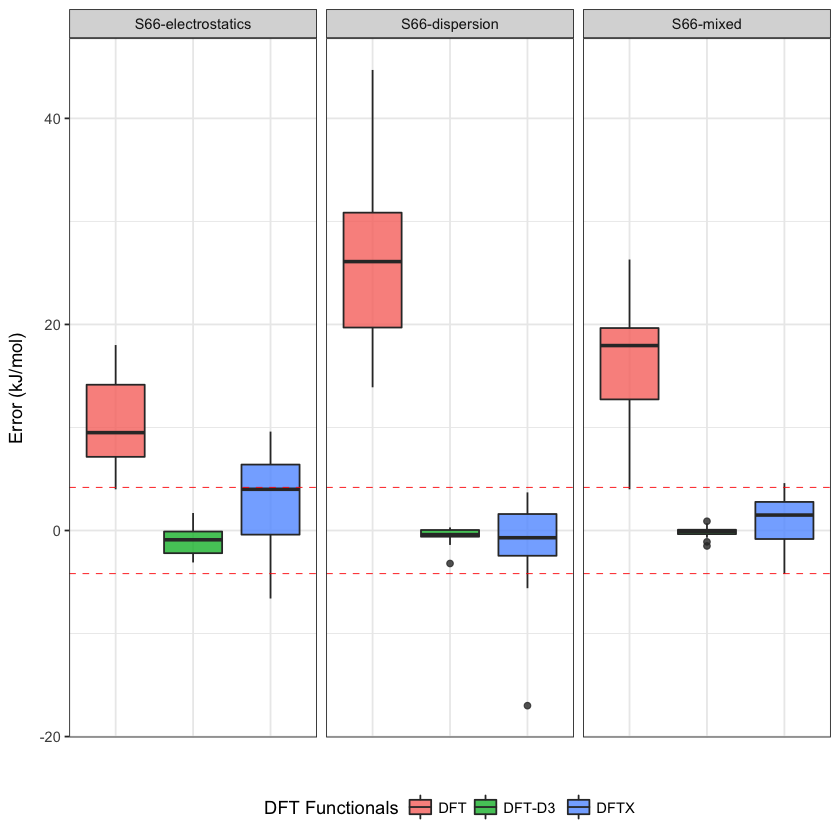

In [18]:
library(ggplot2)
err_wh_box.plt <- ggplot(err_df, aes(x = dft_func, y = err_data, fill = dft_func)) + 
    geom_boxplot(alpha = 0.8, outlier.size=1.5) +
    labs(x = "", y = "Error (kJ/mol)") +
    facet_wrap(~int_type, ncol = 4) +
    theme_bw() +
    guides(fill=guide_legend(title="DFT Functionals")) +
    theme(legend.position="bottom") +
    theme(axis.text.x=element_blank(), axis.ticks.x=element_blank()) +
    geom_hline(yintercept = -4.184, linetype = "dashed", color = "red", size = 0.25) + 
    geom_hline(yintercept = 4.184, linetype = "dashed", color = "red", size = 0.25) 
err_wh_box.plt
ggsave("blyp-avtz-err-fit4.png", err_wh_box.plt, width = 6, height = 4)  

# Applying to IL174
Using the coefficients obtained from the fitting of both data sets, S66 and IL-2IPs. 

In [11]:
il174_blyp_vtz.df <- read.csv("il174_blyp_vtz.csv", header = TRUE, sep = ",")
il174_pbe_vtz.df <- read.csv("il174_pbe_vtz.csv", header = TRUE, sep = ",")

In [55]:
round.fn(data.frame("component" = c("MEAN", "MAD", "MAE", "RMSD", "SD", "Min", "Max") ,"stat" = classic.stats.fn(il174_pbe_vtz.df$int_DFT_D3 - il174_pbe_vtz.df$int_bm)), n = 3)
il174_pbe_vtz.df[which((il174_pbe_vtz.df$int_DFT_D3 - il174_pbe_vtz.df$int_bm) == min((il174_pbe_vtz.df$int_DFT_D3 - il174_pbe_vtz.df$int_bm))),]

component,stat
MEAN,-7.274
MAD,8.154
MAE,8.418
RMSD,10.673
SD,7.830
Min,-32.100
Max,19.200


,dimer,complex,int_DFT,int_DFT_X,int_DFT_C,int_HF_X,int_DFT_D3,int_bm
127,il174-127,c3mpyr-dca-p4,-337.5,-37.8,-29.8,-83.2,-355.7,-323.6


In [57]:
round.fn(data.frame("component" = c("MEAN", "MAD", "MAE", "RMSD", "SD", "Min", "Max") ,"stat" = classic.stats.fn(il174_blyp_vtz.df$int_DFT_D3 - il174_blyp_vtz.df$int_bm)), n = 3)
il174_blyp_vtz.df[which((il174_blyp_vtz.df$int_DFT_D3 - il174_blyp_vtz.df$int_bm) == max((il174_blyp_vtz.df$int_DFT_D3 - il174_blyp_vtz.df$int_bm))),]

component,stat
MEAN,-7.206
MAD,4.744
MAE,7.625
RMSD,8.734
SD,4.947
Min,-32.400
Max,17.200


,dimer,complex,int_DFT,int_DFT_X,int_DFT_C,int_DFT_D3,int_HF_X,int_bm
126,il174-126,c3mpyr-dca-p3,-299.1,-16.5,-26.4,-328.8,-33.9,-346


### PBE/cc-pVTZ

In [46]:
# Fitting Model 1
fit.df <- il174_pbe_vtz.df
c_DFTX <- -1.108
c_HFX <- 0.866
fit.df$int_DFT_fit <- fit.df$int_DFT + c_HFX*fit.df$int_HF_X + c_DFTX*fit.df$int_DFT_X
data.frame("component" = c("MEAN", "MAD", "MAE", "RMSD", "SD", "Min", "Max") ,"stat" = classic.stats.fn(fit.df$int_DFT_fit - fit.df$int_bm))
fit.df[which(fit.df$int_DFT_fit == max(fit.df$int_DFT_fit)),]

component,stat
MEAN,-10.100243
MAD,4.294796
MAE,10.392739
RMSD,11.842894
SD,6.200039
Min,-44.068800
Max,22.627400


,dimer,complex,int_DFT,int_DFT_X,int_DFT_C,int_HF_X,int_DFT_D3,int_bm,int_DFT_fit
126,il174-126,c3mpyr-dca-p3,-311.3,-15.6,-21.8,-33.9,-326.8,-346,-323.3726


In [49]:
### Fitting Model 2
fit.df <- il174_pbe_vtz.df
c_DFTX <- -0.963
c_HFX <- 0.673
c_DFTC <- 0.287
fit.df$int_DFT_fit <- fit.df$int_DFT + c_HFX*fit.df$int_HF_X + c_DFTX*fit.df$int_DFT_X + c_DFTC*fit.df$int_DFT_C
round.fn(data.frame("component" = c("MEAN", "MAD", "MAE", "RMSD", "SD", "Min", "Max") ,"stat" = classic.stats.fn(fit.df$int_DFT_fit - fit.df$int_bm)), n = 3)
fit.df[which(fit.df$int_DFT_fit == max(fit.df$int_DFT_fit)),]

component,stat
MEAN,-9.921
MAD,4.550
MAE,10.334
RMSD,11.658
SD,6.139
Min,-42.045
Max,20.651


,dimer,complex,int_DFT,int_DFT_X,int_DFT_C,int_HF_X,int_DFT_D3,int_bm,int_DFT_fit
126,il174-126,c3mpyr-dca-p3,-311.3,-15.6,-21.8,-33.9,-326.8,-346,-325.3485


In [51]:
# Fitting Model 4
fit.df <- il174_pbe_vtz.df
c_HFX <- 0.709
c_DFTC <- 0.251
fit.df$int_DFT_fit <- fit.df$int_DFT - fit.df$int_DFT_X + c_HFX*fit.df$int_HF_X + c_DFTC*fit.df$int_DFT_C
round.fn(data.frame("component" = c("MEAN", "MAD", "MAE", "RMSD", "SD", "Min", "Max") ,"stat" = classic.stats.fn(fit.df$int_DFT_fit - fit.df$int_bm)), n = 3)
fit.df[which(fit.df$int_DFT_fit == max(fit.df$int_DFT_fit)),]

component,stat
MEAN,-10.065
MAD,4.493
MAE,10.445
RMSD,11.781
SD,6.139
Min,-42.569
Max,20.793


,dimer,complex,int_DFT,int_DFT_X,int_DFT_C,int_HF_X,int_DFT_D3,int_bm,int_DFT_fit
126,il174-126,c3mpyr-dca-p3,-311.3,-15.6,-21.8,-33.9,-326.8,-346,-325.2069


### BLYP/cc-pVTZ

In [59]:
# Fitting Model 1
fit.df <- il174_blyp_vtz.df
c_DFTX <- -1.2
c_HFX <- 1.111
fit.df$int_DFT_fit <- fit.df$int_DFT + c_HFX*fit.df$int_HF_X + c_DFTX*fit.df$int_DFT_X
round.fn(data.frame("component" = c("MEAN", "MAD", "MAE", "RMSD", "SD", "Min", "Max") ,"stat" = classic.stats.fn(fit.df$int_DFT_fit - fit.df$int_bm)), n = 3)
fit.df[which(fit.df$int_DFT_fit == max(fit.df$int_DFT_fit)),]

component,stat
MEAN,-9.586
MAD,6.931
MAE,10.177
RMSD,12.323
SD,7.765
Min,-45.375
Max,29.037


,dimer,complex,int_DFT,int_DFT_X,int_DFT_C,int_DFT_D3,int_HF_X,int_bm,int_DFT_fit
126,il174-126,c3mpyr-dca-p3,-299.1,-16.5,-26.4,-328.8,-33.9,-346,-316.9629


In [61]:
### Fitting Model 2
fit.df <- il174_blyp_vtz.df
c_DFTX <- -0.711
c_HFX <- 0.517
c_DFTC <- 0.726
fit.df$int_DFT_fit <- fit.df$int_DFT + c_HFX*fit.df$int_HF_X + c_DFTX*fit.df$int_DFT_X + c_DFTC*fit.df$int_DFT_C
round.fn(data.frame("component" = c("MEAN", "MAD", "MAE", "RMSD", "SD", "Min", "Max") ,"stat" = classic.stats.fn(fit.df$int_DFT_fit - fit.df$int_bm)), n = 3)
fit.df[which(fit.df$int_DFT_fit == max(fit.df$int_DFT_fit)),]

component,stat
MEAN,-8.954
MAD,6.425
MAE,9.482
RMSD,11.068
SD,6.524
Min,-37.908
Max,21.939


,dimer,complex,int_DFT,int_DFT_X,int_DFT_C,int_DFT_D3,int_HF_X,int_bm,int_DFT_fit
126,il174-126,c3mpyr-dca-p3,-299.1,-16.5,-26.4,-328.8,-33.9,-346,-324.0612


In [63]:
# Fitting Model 4
fit.df <- il174_blyp_vtz.df
c_HFX <- 0.812
c_DFTC <- 0.436
fit.df$int_DFT_fit <- fit.df$int_DFT - fit.df$int_DFT_X + c_HFX*fit.df$int_HF_X + c_DFTC*fit.df$int_DFT_C
round.fn(data.frame("component" = c("MEAN", "MAD", "MAE", "RMSD", "SD", "Min", "Max") ,"stat" = classic.stats.fn(fit.df$int_DFT_fit - fit.df$int_bm)), n = 3)
fit.df[which(fit.df$int_DFT_fit == max(fit.df$int_DFT_fit)),]

component,stat
MEAN,-9.704
MAD,6.943
MAE,10.196
RMSD,12.050
SD,7.161
Min,-42.246
Max,24.363


,dimer,complex,int_DFT,int_DFT_X,int_DFT_C,int_DFT_D3,int_HF_X,int_bm,int_DFT_fit
126,il174-126,c3mpyr-dca-p3,-299.1,-16.5,-26.4,-328.8,-33.9,-346,-321.6372


# Applying to L7
Using the coefficients obtained from the fitting of both data sets, S66 and IL-2IPs. 

In [71]:
l7_blyp_vtz.df <- read.csv("l7_blyp_vtz.csv", header = TRUE, sep = ",")
l7_pbe_vtz.df <- read.csv("l7_pbe_vtz.csv", header = TRUE, sep = ",")

In [72]:
round.fn(data.frame("component" = c("MEAN", "MAD", "MAE", "RMSD", "SD", "Min", "Max") ,"stat" = classic.stats.fn(l7_blyp_vtz.df$int_DFT_D3 - l7_blyp_vtz.df$int_bm)), n = 3)
l7_blyp_vtz.df$
l7_blyp_vtz.df[which((l7_blyp_vtz.df$int_DFT_D3 - l7_blyp_vtz.df$int_bm) == min((l7_blyp_vtz.df$int_DFT_D3 - l7_blyp_vtz.df$int_bm))),]

component,stat
MEAN,1.797
MAD,1.586
MAE,4.503
RMSD,4.899
SD,4.993
Min,-8.120
Max,5.620


dimer,complex,int_bm,int_DFT,int_DFT_X,int_DFT_C,int_DFT_D3,int_HF_X


In [88]:
l7_blyp_vtz.df

dimer,complex,int_bm,int_DFT,int_DFT_X,int_DFT_C,int_DFT_D3,int_HF_X
cluster-4106,octadecane-dimer,-46.28,29.5,-18.6,-48.8,-54.4,-70.9
cluster-4107,guanine-trimer,-10.04,31.9,-0.3,-19.9,-7.7,-18.4
cluster-4108,circumcoronene-adenine,-76.11,40.8,-32.6,-48.7,-73.1,-89.8
cluster-4109,circumcoronene-GCBasePair,-130.75,74.1,-49.7,-87.7,-127.3,-150.3
cluster-4110,phenylalanine-residues-trimer,-107.78,-50.0,-97.7,-49.4,-103.3,-164.3
cluster-4111,coronene-dimer,-101.92,63.9,-32.7,-63.3,-96.3,-105.1
cluster-4112,GCGC-base-pair-stack,NA,50.6,-35.9,-59.3,-62.7,-103.6


In [89]:
l7_pbe_vtz.df$int_DFT_D3 - l7_pbe_vtz.df$int_bm

[1] -5.62  4.64 17.91 32.15  6.98 26.72    NA

In [86]:
round.fn(data.frame("component" = c("MEAN", "MAD", "MAE", "RMSD", "SD", "Min", "Max") ,"stat" = classic.stats.fn(l7_pbe_vtz.df$int_DFT_D3 - l7_pbe_vtz.df$int_bm)), n = 3)
l7_pbe_vtz.df[which((l7_pbe_vtz.df$int_DFT_D3 - l7_pbe_vtz.df$int_bm) == min(l7_pbe_vtz.df$int_DFT_D3 - l7_pbe_vtz.df$int_bm)),]

component,stat
MEAN,13.797
MAD,16.368
MAE,15.670
RMSD,19.018
SD,14.339
Min,-5.620
Max,32.150


dimer,complex,int_bm,int_DFT,int_DFT_X,int_DFT_C,int_DFT_D3,int_HF_X


### PBE/cc-pVTZ

In [74]:
# Fitting Model 1
fit.df <- l7_pbe_vtz.df
c_DFTX <- -1.108
c_HFX <- 0.866
fit.df$int_DFT_fit <- fit.df$int_DFT + c_HFX*fit.df$int_HF_X + c_DFTX*fit.df$int_DFT_X
round.fn(data.frame("component" = c("MEAN", "MAD", "MAE", "RMSD", "SD", "Min", "Max") ,"stat" = classic.stats.fn(fit.df$int_DFT_fit - fit.df$int_bm)), n = 3)
fit.df[which(fit.df$int_DFT_fit == max(fit.df$int_DFT_fit)),]

component,stat
MEAN,38.012
MAD,30.926
MAE,38.012
RMSD,44.462
SD,25.266
Min,9.155
Max,71.577


,dimer,complex,int_bm,int_DFT,int_DFT_X,int_DFT_C,int_DFT_D3,int_HF_X,int_DFT_fit
2,cluster-4107,guanine-trimer,-10.04,18.5,-4,-15,-5.4,-18.4,6.9976


In [77]:
# Fitting Model 2
fit.df <- l7_pbe_vtz.df
c_DFTX <- -0.963
c_HFX <- 0.673
c_DFTC <- 0.287
fit.df$int_DFT_fit <- fit.df$int_DFT + c_HFX*fit.df$int_HF_X + c_DFTX*fit.df$int_DFT_X + c_DFTC*fit.df$int_DFT_C
round.fn(data.frame("component" = c("MEAN", "MAD", "MAE", "RMSD", "SD", "Min", "Max") ,"stat" = classic.stats.fn(fit.df$int_DFT_fit - fit.df$int_bm)), n = 3)
fit.df[which(fit.df$int_DFT_fit == max(fit.df$int_DFT_fit)),]

component,stat
MEAN,38.610
MAD,28.012
MAE,38.610
RMSD,44.505
SD,24.249
Min,14.537
Max,71.390


,dimer,complex,int_bm,int_DFT,int_DFT_X,int_DFT_C,int_DFT_D3,int_HF_X,int_DFT_fit
2,cluster-4107,guanine-trimer,-10.04,18.5,-4,-15,-5.4,-18.4,5.6638


In [79]:
# Fitting Model 4
fit.df <- l7_pbe_vtz.df
c_HFX <- 0.709
c_DFTX <- 0.251
fit.df$int_DFT_fit <- fit.df$int_DFT + c_HFX*fit.df$int_HF_X + c_DFTX*fit.df$int_DFT_X - fit.df$int_DFT_C
round.fn(data.frame("component" = c("MEAN", "MAD", "MAE", "RMSD", "SD", "Min", "Max") ,"stat" = classic.stats.fn(fit.df$int_DFT_fit - fit.df$int_bm)), n = 3)
fit.df[which(fit.df$int_DFT_fit == max(fit.df$int_DFT_fit)),]

component,stat
MEAN,42.898
MAD,66.127
MAE,64.302
RMSD,73.899
SD,65.916
Min,-64.211
Max,115.994


,dimer,complex,int_bm,int_DFT,int_DFT_X,int_DFT_C,int_DFT_D3,int_HF_X,int_DFT_fit
2,cluster-4107,guanine-trimer,-10.04,18.5,-4,-15,-5.4,-18.4,19.4504


### BLYP/cc-pVTZ

In [81]:
# Fitting Model 1
fit.df <- l7_blyp_vtz.df
c_DFTX <- -1.2
c_HFX <- 1.111
fit.df$int_DFT_fit <- fit.df$int_DFT + c_HFX*fit.df$int_HF_X + c_DFTX*fit.df$int_DFT_X
round.fn(data.frame("component" = c("MEAN", "MAD", "MAE", "RMSD", "SD", "Min", "Max") ,"stat" = classic.stats.fn(fit.df$int_DFT_fit - fit.df$int_bm)), n = 3)
fit.df[which(fit.df$int_DFT_fit == max(fit.df$int_DFT_fit)),]

component,stat
MEAN,45.956
MAD,49.153
MAE,48.461
RMSD,59.689
SD,41.726
Min,-7.517
Max,97.507


,dimer,complex,int_bm,int_DFT,int_DFT_X,int_DFT_C,int_DFT_D3,int_HF_X,int_DFT_fit
2,cluster-4107,guanine-trimer,-10.04,31.9,-0.3,-19.9,-7.7,-18.4,11.8176


In [36]:
data.frame("component" = c("MEAN", "MAD", "MAE", "RMSD", "SD", "Min", "Max") ,"stat" = classic.stats.fn(fit.df$int_DFT_D3 - fit.df$int_bm))

component,stat
MEAN,1.796667
MAD,1.586382
MAE,4.503333
RMSD,4.899446
SD,4.993182
Min,-8.120000
Max,5.620000


In [83]:
# Fitting Model 2
fit.df <- l7_blyp_vtz.df
c_DFTX <- -0.711
c_HFX <- 0.517
c_DFTC <- 0.726
fit.df$int_DFT_fit <- fit.df$int_DFT + c_HFX*fit.df$int_HF_X + c_DFTX*fit.df$int_DFT_X + c_DFTC*fit.df$int_DFT_C
round.fn(data.frame("component" = c("MEAN", "MAD", "MAE", "RMSD", "SD", "Min", "Max") ,"stat" = classic.stats.fn(fit.df$int_DFT_fit - fit.df$int_bm)), n = 3)
fit.df[which(fit.df$int_DFT_fit == max(fit.df$int_DFT_fit)),]

component,stat
MEAN,47.908
MAD,39.394
MAE,47.908
RMSD,60.143
SD,39.831
Min,6.437
Max,98.811


,dimer,complex,int_bm,int_DFT,int_DFT_X,int_DFT_C,int_DFT_D3,int_HF_X,int_DFT_fit
2,cluster-4107,guanine-trimer,-10.04,31.9,-0.3,-19.9,-7.7,-18.4,8.1531


In [85]:
# Fitting Model 4
fit.df <- l7_blyp_vtz.df
c_HFX <- 0.812
c_DFTC <- 0.436
fit.df$int_DFT_fit <- fit.df$int_DFT + c_HFX*fit.df$int_HF_X - fit.df$int_DFT_X + c_DFTC*fit.df$int_DFT
round.fn(data.frame("component" = c("MEAN", "MAD", "MAE", "RMSD", "SD", "Min", "Max") ,"stat" = classic.stats.fn(fit.df$int_DFT_fit - fit.df$int_bm)), n = 3)
fit.df[which(fit.df$int_DFT_fit == max(fit.df$int_DFT_fit)),]

component,stat
MEAN,81.897
MAD,74.005
MAE,81.897
RMSD,100.107
SD,63.065
Min,0.268
Max,164.814


,dimer,complex,int_bm,int_DFT,int_DFT_X,int_DFT_C,int_DFT_D3,int_HF_X,int_DFT_fit
6,cluster-4111,coronene-dimer,-101.92,63.9,-32.7,-63.3,-96.3,-105.1,39.1192
